In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import scanpy as sc
from sc_target_evidence_utils.cellontology_utils import *
from sc_target_evidence_utils.plotting_utils import *

In [322]:
def print_ontology(term_id):
    print(f"{ontology2name(term_id, graph)} ({term_id})")
    
# def test_get_ancestors():
#     graph = get_cellontology_graph("./data/")
#     term_id = 'CL:0000985'
#     levels = 3

#     expected_ancestors = [
#         term_id,
#         'CL:0000974', # long-lived plasma cell
#         'CL:0000786', # plasma cell
#         'CL:0000946', # antibody secreting cell
#     ]   

#     ancestors = get_ancestors(term_id, graph, levels)
#     assert set(ancestors) == set(expected_ancestors), "Ancestors don't match"
#     assert all([term.startswith('CL:') for term in ancestors]), "Ancestors must be cell ontology terms"

#     # Test that the order is right
#     assert ancestors[0] == term_id
#     assert ancestors[-1] == 'CL:0000946'

In [341]:
data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
disease_ontology_id = 'MONDO:0005097'
pbulk_adata = sc.read_h5ad(f'{data_dir}/cellxgene_targets_{disease_ontology_id.replace(":","_")}.pbulk_all_OT_targets.h5ad')

In [342]:
import scipy
from sc_target_evidence_utils import cellontology_utils


def prep_pbulk_adata(pbulk_adata, data_dir):
        graph = cellontology_utils.get_cellontology_graph(data_dir)
        pbulk_adata.obs['high_level_cell_type'] = [f'{cellontology_utils.ontology2name(x, graph)} ({x})' for x in pbulk_adata.obs['high_level_cell_type_ontology_term_id'].tolist()]
        pbulk_adata.obs['sample_id'] = ['-'.join(x[1:]) for x in pbulk_adata.obs_names.str.split("-")]

        ## Run PCA
        pbulk_adata.layers['counts'] = pbulk_adata.X.copy()
        cpms = scipy.sparse.csr_matrix(pbulk_adata.X.T / pbulk_adata.obs['size_factors'].values.flatten()) * 1000000
        pbulk_adata.X  = np.log1p(cpms).T
        sc.tl.pca(pbulk_adata, n_comps=20, use_highly_variable=False, random_state=42)

        ## Add dendrogram
        sc.tl.dendrogram(pbulk_adata, groupby='high_level_cell_type', use_rep='X_pca')
        pbulk_adata.X  = pbulk_adata.layers['counts'].copy()

In [3]:
from sc_target_evidence_utils import DE_utils

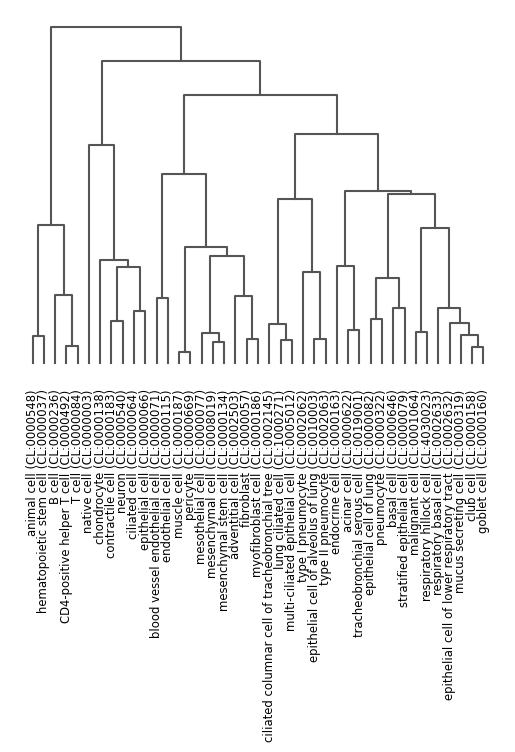

<Axes: >

In [352]:
# sc.pl.dendrogram(pbulk_adata, groupby='high_level_cell_type')


/nfs/team205/ed6/miniconda3/envs/sc-target-evidence-env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


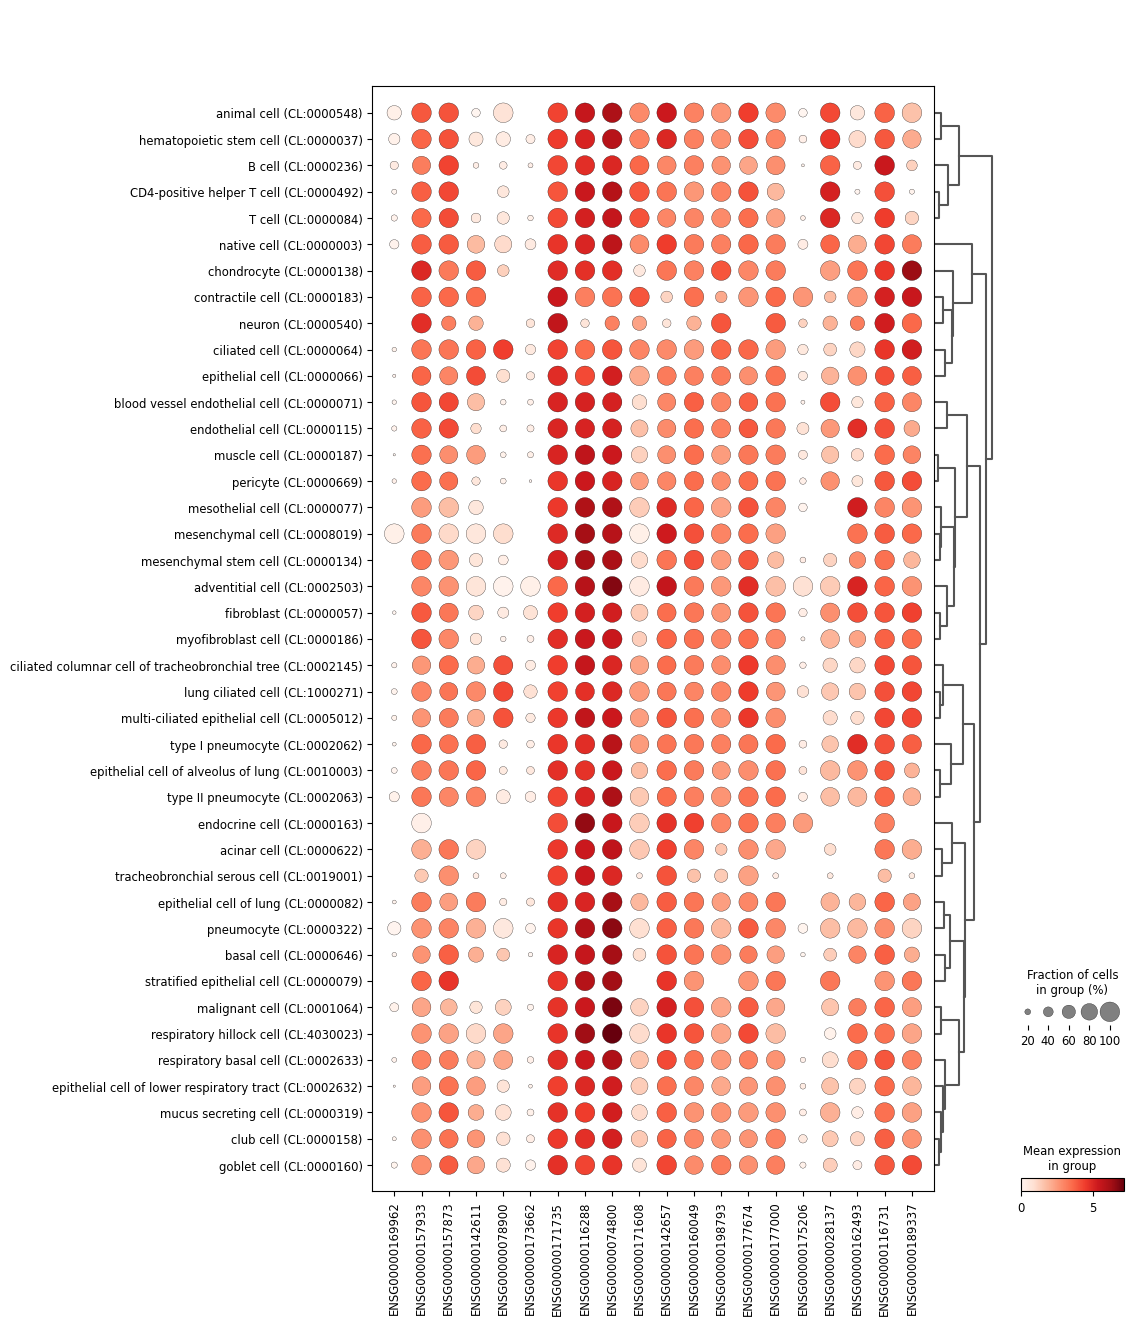

In [356]:
sc.pl.dotplot(pbulk_adata, pbulk_adata.var_names[0:20], groupby='high_level_cell_type', dendrogram=True)

In [12]:
import scanpy as sc
from sc_target_evidence_utils import DE_utils, cellontology_utils

def clean_disease(pbulk_adata):
    '''Uniform disease naming.'''        
    DISEASE_RENAME = {'cardiomyopathy':[
        'arrhythmogenic right ventricular cardiomyopathy',
        'dilated cardiomyopathy',
        'non-compaction cardiomyopathy'],
    'renal cell carcinoma':['chromophobe renal cell carcinoma', 'clear cell renal carcinoma'],
    'colorectal cancer': ['colorectal cancer', 'colorectal neoplasm'],
        'non-small cell lung carcinoma':['lung large cell carcinoma', 'non-small cell lung carcinoma']
        }

    disease_rename_rev = {x:k for k,v in DISEASE_RENAME.items() for x in v }

    pbulk_adata.obs['disease_name_original'] = pbulk_adata.obs['disease'].copy()
    pbulk_adata.obs['disease'] = [disease_rename_rev[x] if x in disease_rename_rev.keys() else x for x in pbulk_adata.obs.disease]

disease_ontology_id = 'MONDO:0004994'
data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

# Load pseudobulk data
pbulk_adata = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_OT_targets.h5ad')

# clean pseudobulk data
clean_disease(pbulk_adata)
graph = cellontology_utils.get_cellontology_graph(data_dir)
pbulk_adata = pbulk_adata[pbulk_adata.obs['high_level_cell_type_ontology_term_id'] != 'low_quality_annotation'].copy()
pbulk_adata.obs['high_level_cell_type'] = [f'{cellontology_utils.ontology2name(x, graph)} ({x})' for x in pbulk_adata.obs['high_level_cell_type_ontology_term_id'].tolist()]
pbulk_adata.obs['sample_id'] = ['-'.join(x[1:]) for x in pbulk_adata.obs_names.str.split("-")]
pbulk_adata.obs['disease_ontology_id'] = disease_ontology_id

# Run DE analysis
ct_res = DE_utils.celltype_marker_targets(pbulk_adata)
disease_res, bulk_res = DE_utils.disease_marker_targets(pbulk_adata)

# Save results
ct_res.to_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.all_targets.csv')
disease_res.to_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.all_targets.csv')
bulk_res.to_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.all_targets.csv')


In [ ]:
ct_res_all

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,gene_id,high_level_cell_type_ontology_term_id,confounder_warning,log_adj_pval
0,0.000485,0.002616,13.434132,1,68.020925,-10.000000,SLC2A5,ENSG00000142583,CL:0000066,1,2.582313
1,0.929347,0.963499,0.007920,1,68.020925,-0.069700,TMEM201,ENSG00000188807,CL:0000066,1,0.016149
2,0.014106,0.039044,6.347916,1,68.020925,2.914636,VCAM1,ENSG00000162692,CL:0000066,1,1.408449
3,0.000028,0.000392,20.143419,1,68.020925,4.710744,S1PR1,ENSG00000170989,CL:0000066,1,3.406436
4,0.369914,0.592769,0.814718,1,68.020925,2.249380,ADORA3,ENSG00000282608,CL:0000066,1,0.227114
...,...,...,...,...,...,...,...,...,...,...,...
739,0.006777,0.027107,9.564310,1,16.536488,10.000000,CD40LG,ENSG00000102245,CL:0011026,1,1.566913
740,0.584151,1.000000,0.311648,1,16.536488,-10.000000,RPL17-C18orf32,ENSG00000215472,CL:0011026,1,-0.000000
741,1.000000,1.000000,0.000000,1,16.536488,0.000000,CXADRP1,ENSG00000214319,CL:0011026,1,-0.000000
742,1.000000,1.000000,0.000000,1,16.536488,0.000000,H3P28,ENSG00000220347,CL:0011026,1,-0.000000


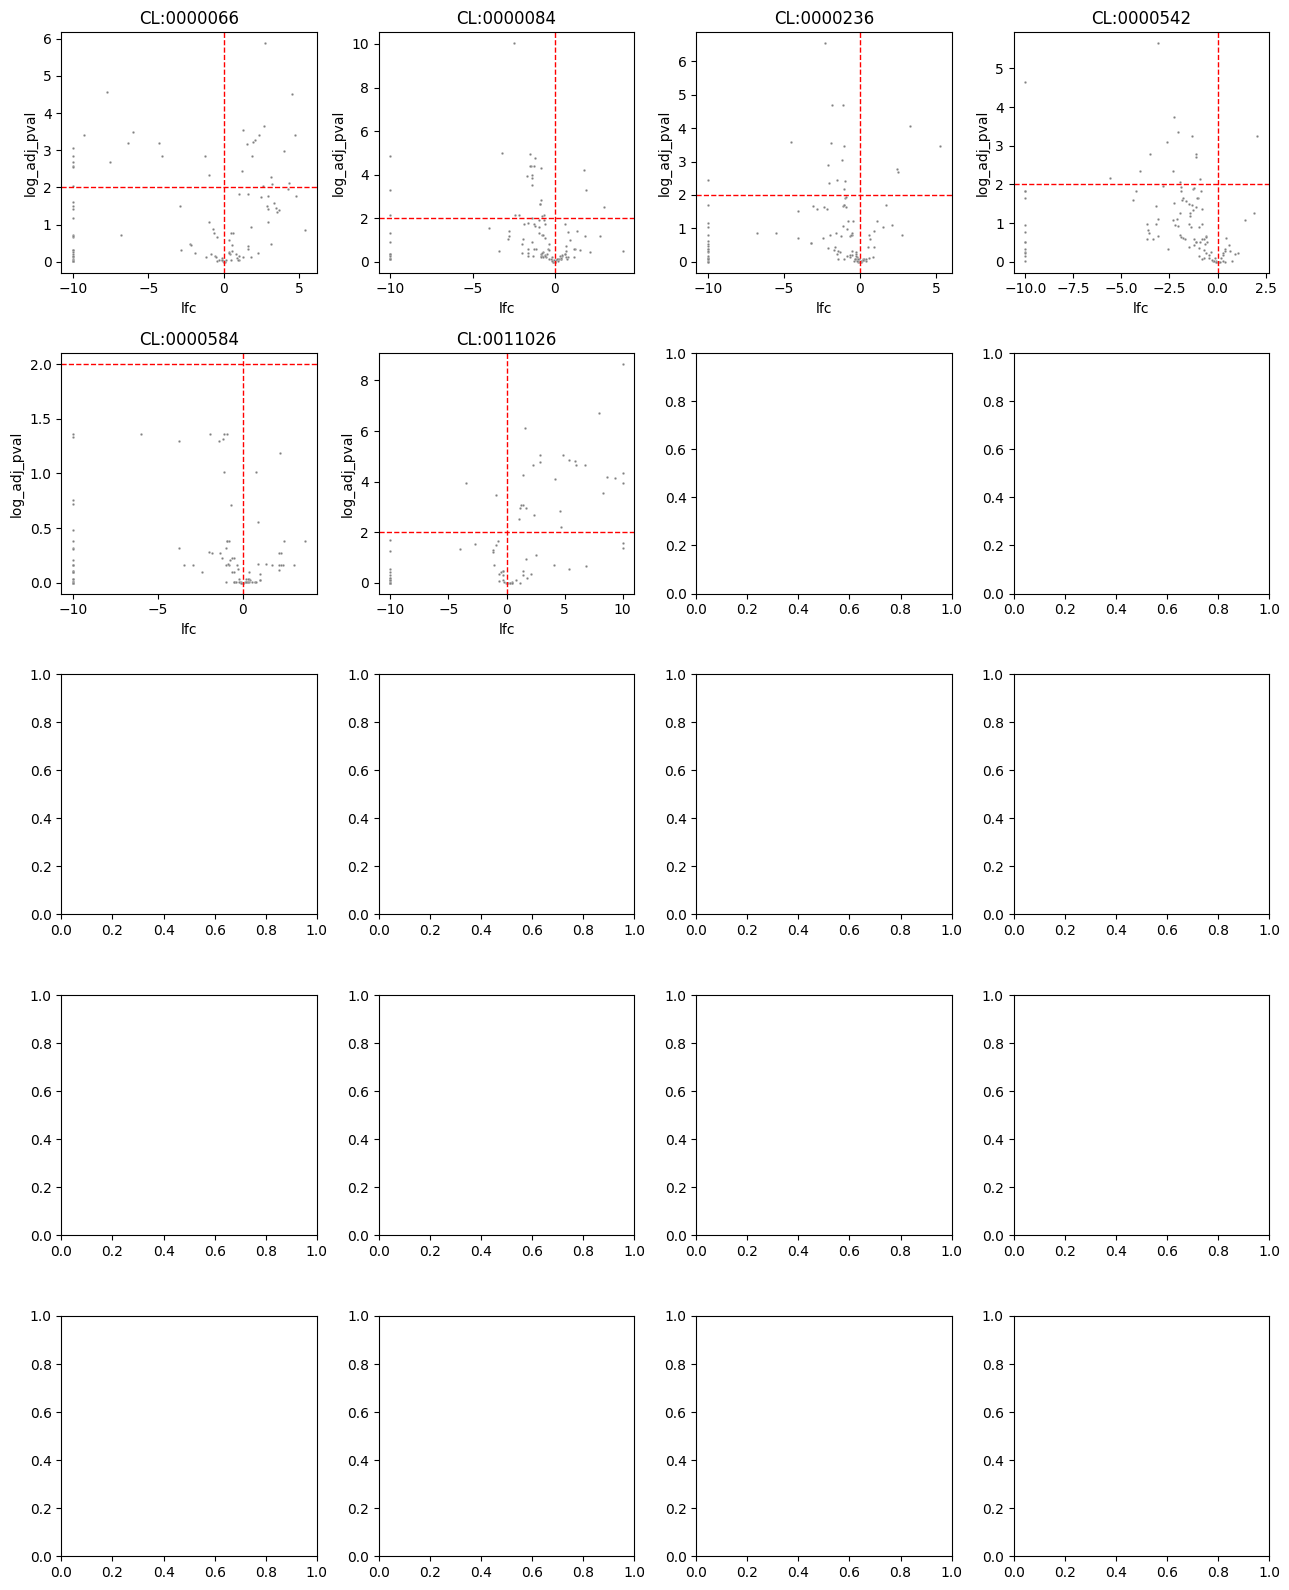

In [101]:

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 16))

for i, ct in enumerate(ct_res_all.high_level_cell_type_ontology_term_id.unique().tolist()):
    row_i, col_i = divmod(i, ncols)  # Calculate the row and column indices

    ax = axes[row_i, col_i]  # Get the corresponding subplot axis

    sns.scatterplot(data=ct_res_all[ct_res_all.high_level_cell_type_ontology_term_id == ct],
                    s=3, color='grey',
                    x='lfc', y='log_adj_pval', ax=ax)
    # sns.scatterplot(data=ct_res_all[(ct_res_all.high_level_cell_type == ct) & (ct_res_all.is_drug_target)],
    #                 s=9, color='black',
    #                 x='lfc', y='log_adj_pval', ax=ax)

    ax.set_title(ct.replace(" (CL:", "\n(CL:"))
    ax.axvline(0, color='r', linewidth=1, linestyle='--')
    ax.axhline(2, color='r', linewidth=1, linestyle='--')

plt.tight_layout()  # Adjust subplot spacing
plt.show()

In [62]:
min_replicates = 3
pbulk_adata_test = pbulk_adata.copy()
n_replicates = pbulk_adata_test.obs.value_counts(['high_level_cell_type_ontology_term_id', 'disease']).reset_index()
n_replicates = n_replicates[n_replicates['count'] >= min_replicates].groupby(['high_level_cell_type_ontology_term_id']).count()['count']
ct_labels = n_replicates[n_replicates > 1].index.tolist()
    

['CL:0000064',
 'CL:0000084',
 'CL:0000151',
 'CL:0000313',
 'CL:0000786',
 'CL:0002480',
 'CL:0002633',
 'low_quality_annotation']

In [ ]:
min_replicates=3
pbulk_adata_test = pbulk_adata[pbulk_adata.obs['disease'] == 'normal'].copy()

# Exclude cell types with insufficient replicates
n_replicates = pbulk_adata_test.obs.value_counts(['high_level_cell_type_ontology_term_id', 'disease']).reset_index()
ct_labels = n_replicates[n_replicates['count'] >= min_replicates]['high_level_cell_type_ontology_term_id'].unique()
pbulk_adata_test = pbulk_adata_test[pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].isin(ct_labels)].copy()

pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].str.replace(":", "_").astype('category')
ct_categories = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].cat.categories.tolist()

In [6]:
## Select confounders with multiple values
for c in confounders:
    if pbulk_adata_test.obs[c].nunique() == 1:
        confounders.remove(c)

confounders_str = '+'.join(confounders)


'assay'

In [24]:
import pandas as pd
celltype_de_results = pd.DataFrame()
for ct_term in pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].unique():
    print(ct_term)
    # Reorder cell type categories to include in design matrix
    ct_categories.remove(ct_term)
    ct_categories.append(ct_term)
    pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].cat.reorder_categories(ct_categories)
    
    de_results = DE_utils._run_glmGamPoi_DE(
        pbulk_adata_test,
            design = f'~ {confounders_str} + high_level_cell_type_ontology_term_id', # + n_cells
            ref_level = None,
            contrast = f'high_level_cell_type_ontology_term_id{ct_term}'
            )

CL_0000066
CL_0000084
CL_0000763
CL_0000057


Exception ignored from cffi callback <function _processevents at 0x7f34b69bb420>:
Traceback (most recent call last):
  File "/nfs/team205/ed6/miniconda3/envs/sc-target-evidence-env/lib/python3.11/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


CL_0002079
low_quality_annotation


In [22]:
pbulk_adata_test.obs['suspension_type'].unique()

['cell']
Categories (1, object): ['cell']

In [2]:
import anndata
anndata.__version__

'0.9.1'

In [19]:
ct_counts = pbulk_adata.obs["high_level_cell_type_ontology_term_id"].value_counts()
ct_counts[ct_counts > 5].index.tolist()

['CL:0000066',
 'CL:0002079',
 'CL:0000057',
 'low_quality_annotation',
 'CL:0000163']